In [1]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:64'

In [2]:
import torch
import pandas as pd
import numpy as np
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from torch.nn import Linear
from torch.nn.functional import l1_loss
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torch import optim
from torch.utils.data import DataLoader
from statistics import mean
from copy import deepcopy

In [3]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
df = pd.read_parquet('train.pqt')

In [5]:
samples = []
samples_sizes = [len(df) // 5] * 5
samples_sizes[-1] += len(df) % samples_sizes[-1]
for size in samples_sizes:
    samples.append(df.sample(size, weights=df['weight']))
    df.drop(samples[-1].index, inplace=True)
    samples[-1].reset_index(drop=True, inplace=True)

In [6]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df: pd.DataFrame, transforms: transforms.Compose = None):
        self.transforms = transforms
        self.df = df

    def __getitem__(self, idx):
        img = Image.open(BytesIO(self.df['img'][idx])).convert('RGB')
        rate = self.df['rate'][idx]
        rate = torch.Tensor([rate])
        weight = self.df['weight'][idx]
        weight = torch.Tensor([weight])

        if self.transforms is not None:
            img = self.transforms(img)
        return img, rate, weight

    def __len__(self):
        return len(self.df)

In [7]:
class SquarePad:

	def __call__(self, image):
		w, h = image.size
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
		padding = (hp, vp, hp, vp)
		return F.pad(image, padding, 0, 'constant')


transform = transforms.Compose([
	SquarePad(),
    transforms.Resize((256, 256)),
    transforms.RandomCrop((256, 256), padding=16),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(degrees=360),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=(0, 1)),
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
	SquarePad(),
	transforms.Resize((256, 256)),
	transforms.ToTensor(),
])

In [8]:
model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1)
model.classifier[1] = Linear(model.classifier[1].in_features, 1)

In [9]:
model.requires_grad_(True)
model = model.train().to(device)

all_params = sum(param.numel() for param in model.parameters())
grad_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print(all_params)
print(grad_params)

20178769
20178769


In [10]:
def weighted_mse_loss(inputs: torch.Tensor, targets: torch.Tensor, weights: torch.Tensor=None):
    loss = (inputs - targets) ** 2
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

def weighted_l1_loss(inputs: torch.Tensor, targets: torch.Tensor, weights: torch.Tensor=None):
    loss = (inputs - targets).absolute()
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

In [11]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

In [12]:
class TrainResult:

    def __init__(self, losses: list[float], diffs: list[float]) -> None:
        self.losses = losses
        self.diffs = diffs

    @classmethod
    def concat(cls, values: list):
        return cls(
            [item for sublist in values for item in sublist.losses],
            [item for sublist in values for item in sublist.diffs]
        )


class TestResult:

    def __init__(self, accuracy: float, loss: float, diff: float,
                min_rate: float, max_rate: float, max_diff: float, df: pd.DataFrame) -> None:
        self.accuracy = accuracy
        self.loss = loss
        self.diff = diff
        self.min_rate = min_rate
        self.max_rate = max_rate
        self.max_diff = max_diff
        self.df = df
    
    @classmethod
    def concat(cls, values: list):
        df = pd.concat([i.df for i in values], ignore_index=True)
        df['rate'] = pd.cut(df['rate'], bins=np.arange(0.0, 1.001, 0.05)).apply(lambda x: x.right)
        df = df.groupby('range', as_index=False).mean()
        return cls(
            mean([i.accuracy for i in values]),
            mean([i.loss for i in values]),
            mean([i.diff for i in values]),
            min([i.min_rate for i in values]),
            max([i.max_rate for i in values]),
            max([i.max_diff for i in values]),
            df
        )

In [14]:
def train_loop(dataloader, model, loss_fn, optimizer, batch_size) -> TrainResult:
    model.train()

    size = len(dataloader.dataset)
    size_batches = len(dataloader)
    checkpoint = 100
    running_loss = 0.0
    running_diff = 0.0
    losses = []
    diffs = []
    min_rate = float('inf')
    max_rate = float('-inf')

    for batch, (x, y, w) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
        w = w.to(device)

        pred = model(x)
        loss = loss_fn(pred, y, w)
        diff = l1_loss(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        min_ = pred.detach().flatten().min().item()
        max_ = pred.detach().flatten().max().item()
        if min_ < min_rate:
            min_rate = min_
        if max_ > max_rate:
            max_rate = max_

        running_loss += loss.item()
        running_diff += diff
        is_last_batch = batch + 1 == size_batches
        batch_edge = ((batch + 1) % checkpoint) or checkpoint

        if is_last_batch or batch_edge == checkpoint:
            current = (batch * batch_size) + len(x)
            point_loss = running_loss / batch_edge
            point_diff = running_diff / batch_edge
            losses.append(point_loss)
            diffs.append(point_diff)
            print(f"Avg diff: {point_diff:>1f}, Avg loss: {point_loss:>1f}, Min rate: {min_rate:>1f}, Max rate: {max_rate:>1f}  [{current:>5d}/{size:>5d}]")
            running_loss = 0.0
            running_diff = 0.0
            min_rate = float('inf')
            max_rate = float('-inf')

    return TrainResult(losses, diffs)

In [15]:
def test_loop(dataloader, model, loss_fn) -> TestResult:
    model.eval()

    size = len(dataloader.dataset)
    running_loss = .0
    accuracy = .0
    min_rate = float('inf')
    max_rate = float('-inf')
    max_diff = float('-inf')
    plot_x = np.array([], dtype=np.float32)
    plot_y = np.array([], dtype=np.float32)

    with torch.no_grad():
        for x, y, w in dataloader:
            x = x.to(device)
            y = y.to(device)
            w = w.to(device)

            pred = model(x)
            loss = loss_fn(pred, y, w)
            running_loss += loss.item() * y.shape[0]

            diffs = (pred - y).flatten()
            max_diff_ = diffs.absolute().max().item()
            max_diff = max_diff_ if max_diff_ > max_diff else max_diff

            accuracy += diffs.absolute().sum().item()
            min_ = pred.flatten().min().item()
            max_ = pred.flatten().max().item()
            if min_ < min_rate:
                min_rate = min_
            if max_ > max_rate:
                max_rate = max_

            plot_x = np.concatenate([plot_x, y.flatten().cpu().numpy()])
            plot_y = np.concatenate([plot_y, diffs.cpu().numpy()])

    running_loss /= size
    running_diff = accuracy / size
    accuracy = running_diff * 2 if running_diff else 0.0

    df = pd.DataFrame({'rate': plot_x, 'diffs': plot_y})
    df['abs_diffs'] = df['diffs'].copy().abs()
    df['range'] = pd.cut(df['rate'], bins=np.arange(0.0, 1.001, 0.05)).apply(lambda x: x.right)
    df = df.groupby('range', as_index=False).mean()

    return TestResult(accuracy, running_loss, running_diff, min_rate, max_rate, max_diff, df)

In [16]:
batch_size = 8
epochs = []
train_y = []
test_y = []
best_state = {
    'accuracy': float('-inf'),
    'loss': float('inf'),
    'diff': float('inf'),
    'min_rate': float('inf'),
    'max_rate': float('-inf'),
    'max_diff': float('-inf'),
    'epoch': None,
    'state': None
}
results_template = 'Test Results: \n Accuracy: {:>1f}, Avg loss: {:>1f}, Min rate: {:>1f}, Max rate: {:>1f}, Max diff {:>1f}'

Epoch 1
-------------------------------

k-1
Avg diff: 0.189568, Avg loss: 0.066588, Min rate: -0.224834, Max rate: 1.374869  [  800/10285]
Avg diff: 0.146174, Avg loss: 0.035906, Min rate: 0.062532, Max rate: 1.353885  [ 1600/10285]
Avg diff: 0.138597, Avg loss: 0.039540, Min rate: 0.053302, Max rate: 1.029720  [ 2400/10285]
Avg diff: 0.120856, Avg loss: 0.029280, Min rate: -0.039945, Max rate: 0.949762  [ 3200/10285]
Avg diff: 0.109817, Avg loss: 0.023147, Min rate: 0.099684, Max rate: 0.896551  [ 4000/10285]
Avg diff: 0.101681, Avg loss: 0.021327, Min rate: 0.198056, Max rate: 0.904325  [ 4800/10285]
Avg diff: 0.100611, Avg loss: 0.020611, Min rate: 0.125056, Max rate: 0.954761  [ 5600/10285]
Avg diff: 0.100450, Avg loss: 0.019782, Min rate: 0.137288, Max rate: 0.960082  [ 6400/10285]
Avg diff: 0.089854, Avg loss: 0.015329, Min rate: 0.197773, Max rate: 0.817442  [ 7200/10285]
Avg diff: 0.093838, Avg loss: 0.015376, Min rate: 0.153851, Max rate: 0.869433  [ 8000/10285]
Avg diff: 0.0

C:\Users\yrasi\AppData\Local\Temp\ipykernel_2148\2076441446.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('range', as_index=False).mean()


Test Results: 
 Accuracy: 0.171858, Avg loss: 0.018888, Min rate: 0.014268, Max rate: 1.050646, Max diff 0.625471


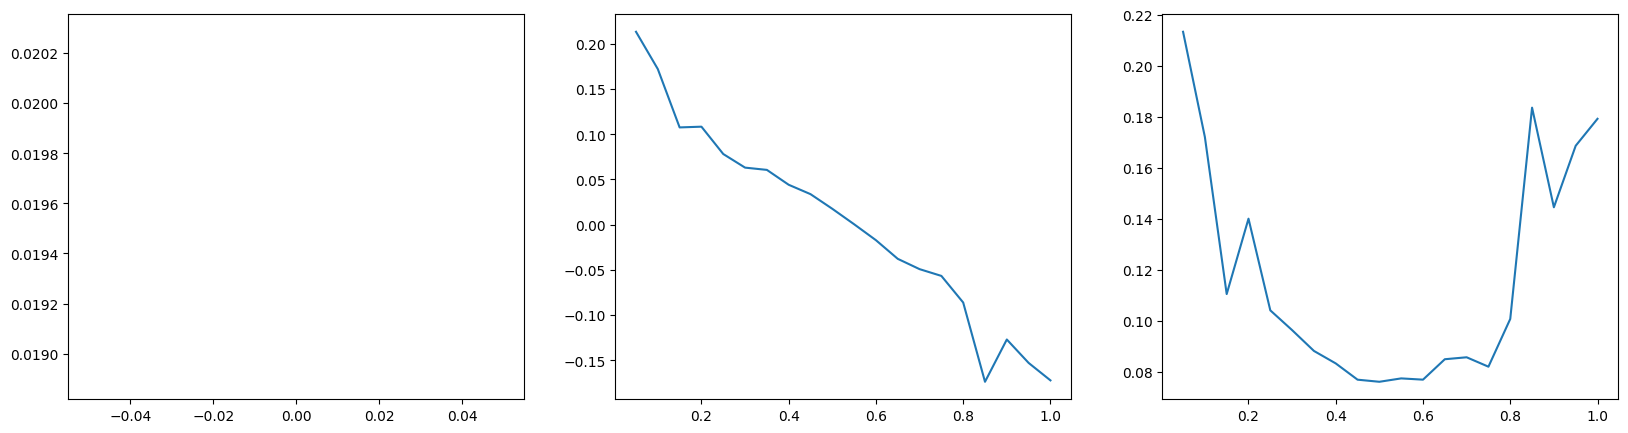

Epoch 2
-------------------------------

k-1
Avg diff: 0.073436, Avg loss: 0.008510, Min rate: 0.187723, Max rate: 0.818798  [  800/10285]
Avg diff: 0.072819, Avg loss: 0.009353, Min rate: 0.185735, Max rate: 1.000683  [ 1600/10285]
Avg diff: 0.069720, Avg loss: 0.009034, Min rate: 0.129401, Max rate: 1.006178  [ 2400/10285]
Avg diff: 0.073251, Avg loss: 0.010193, Min rate: 0.074421, Max rate: 0.934124  [ 3200/10285]
Avg diff: 0.071042, Avg loss: 0.008100, Min rate: 0.095587, Max rate: 0.899053  [ 4000/10285]
Avg diff: 0.070469, Avg loss: 0.008140, Min rate: 0.084838, Max rate: 1.042982  [ 4800/10285]
Avg diff: 0.075185, Avg loss: 0.009029, Min rate: 0.134142, Max rate: 1.109445  [ 5600/10285]
Avg diff: 0.065754, Avg loss: 0.006899, Min rate: -0.039717, Max rate: 0.943473  [ 6400/10285]
Avg diff: 0.072412, Avg loss: 0.008484, Min rate: 0.155164, Max rate: 1.179692  [ 7200/10285]
Avg diff: 0.071579, Avg loss: 0.009068, Min rate: 0.057782, Max rate: 1.026140  [ 8000/10285]
Avg diff: 0.07

C:\Users\yrasi\AppData\Local\Temp\ipykernel_2148\2076441446.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('range', as_index=False).mean()


Test Results: 
 Accuracy: 0.137560, Avg loss: 0.009063, Min rate: -0.012605, Max rate: 1.130091, Max diff 0.439301


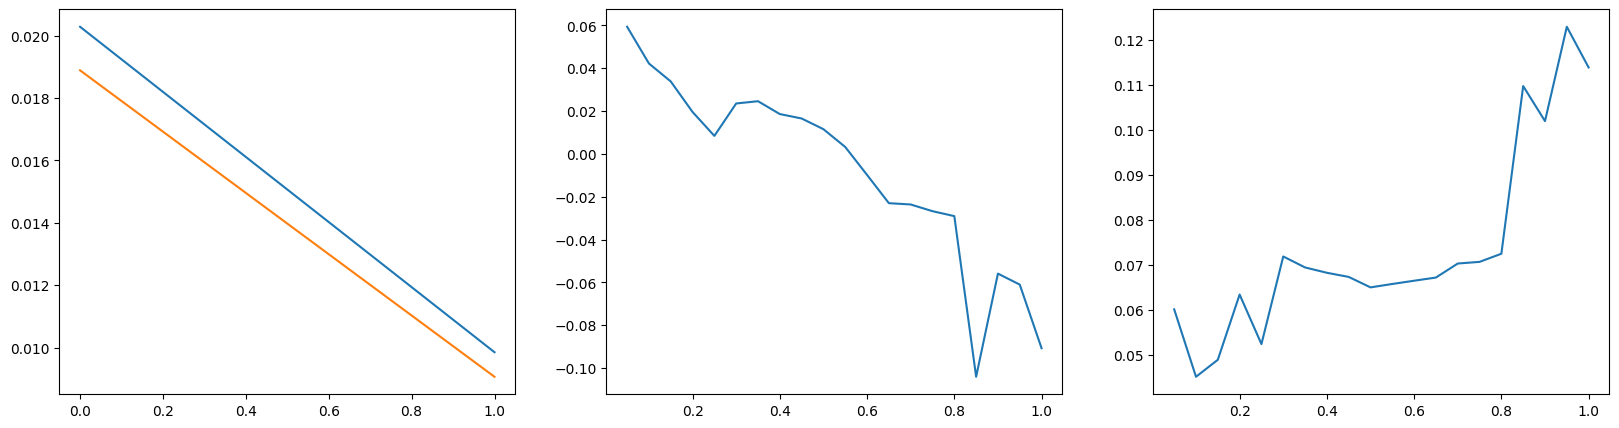

Epoch 3
-------------------------------

k-1
Avg diff: 0.058464, Avg loss: 0.005561, Min rate: 0.026286, Max rate: 1.049706  [  800/10285]
Avg diff: 0.061005, Avg loss: 0.005387, Min rate: 0.108872, Max rate: 1.034259  [ 1600/10285]
Avg diff: 0.060171, Avg loss: 0.005942, Min rate: 0.089126, Max rate: 0.951497  [ 2400/10285]
Avg diff: 0.056974, Avg loss: 0.005198, Min rate: 0.091922, Max rate: 1.038761  [ 3200/10285]
Avg diff: 0.057403, Avg loss: 0.005478, Min rate: -0.004311, Max rate: 1.087714  [ 4000/10285]
Avg diff: 0.057466, Avg loss: 0.005058, Min rate: 0.012884, Max rate: 0.888246  [ 4800/10285]
Avg diff: 0.055468, Avg loss: 0.004617, Min rate: 0.117752, Max rate: 0.972880  [ 5600/10285]
Avg diff: 0.056188, Avg loss: 0.004955, Min rate: 0.120270, Max rate: 0.985592  [ 6400/10285]
Avg diff: 0.060473, Avg loss: 0.005571, Min rate: 0.121346, Max rate: 0.980239  [ 7200/10285]
Avg diff: 0.060965, Avg loss: 0.006582, Min rate: 0.102538, Max rate: 1.032265  [ 8000/10285]
Avg diff: 0.05

C:\Users\yrasi\AppData\Local\Temp\ipykernel_2148\2076441446.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('range', as_index=False).mean()


Test Results: 
 Accuracy: 0.111358, Avg loss: 0.005117, Min rate: -0.015527, Max rate: 1.209203, Max diff 0.459088


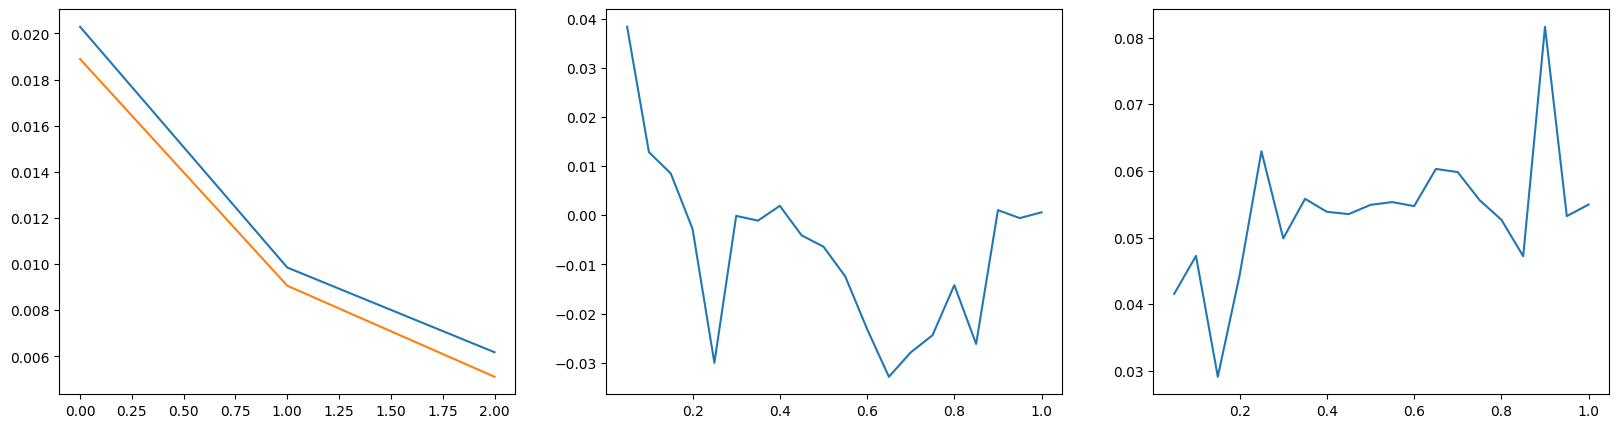

Epoch 4
-------------------------------

k-1
Avg diff: 0.050933, Avg loss: 0.004001, Min rate: -0.004835, Max rate: 1.066050  [  800/10285]
Avg diff: 0.053869, Avg loss: 0.004701, Min rate: 0.095618, Max rate: 0.986365  [ 1600/10285]
Avg diff: 0.051702, Avg loss: 0.004164, Min rate: 0.173870, Max rate: 0.978706  [ 2400/10285]
Avg diff: 0.050470, Avg loss: 0.003661, Min rate: 0.107520, Max rate: 0.978894  [ 3200/10285]
Avg diff: 0.049701, Avg loss: 0.003873, Min rate: 0.064179, Max rate: 1.026386  [ 4000/10285]
Avg diff: 0.048898, Avg loss: 0.003451, Min rate: 0.126936, Max rate: 1.002330  [ 4800/10285]
Avg diff: 0.049299, Avg loss: 0.003426, Min rate: 0.136568, Max rate: 0.992203  [ 5600/10285]
Avg diff: 0.048117, Avg loss: 0.003665, Min rate: -0.048917, Max rate: 0.997611  [ 6400/10285]
Avg diff: 0.054512, Avg loss: 0.004886, Min rate: 0.068911, Max rate: 0.991136  [ 7200/10285]
Avg diff: 0.049861, Avg loss: 0.004007, Min rate: 0.110382, Max rate: 1.010489  [ 8000/10285]
Avg diff: 0.0

C:\Users\yrasi\AppData\Local\Temp\ipykernel_2148\2076441446.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('range', as_index=False).mean()


Test Results: 
 Accuracy: 0.096074, Avg loss: 0.003584, Min rate: -0.047843, Max rate: 1.021147, Max diff 0.392533


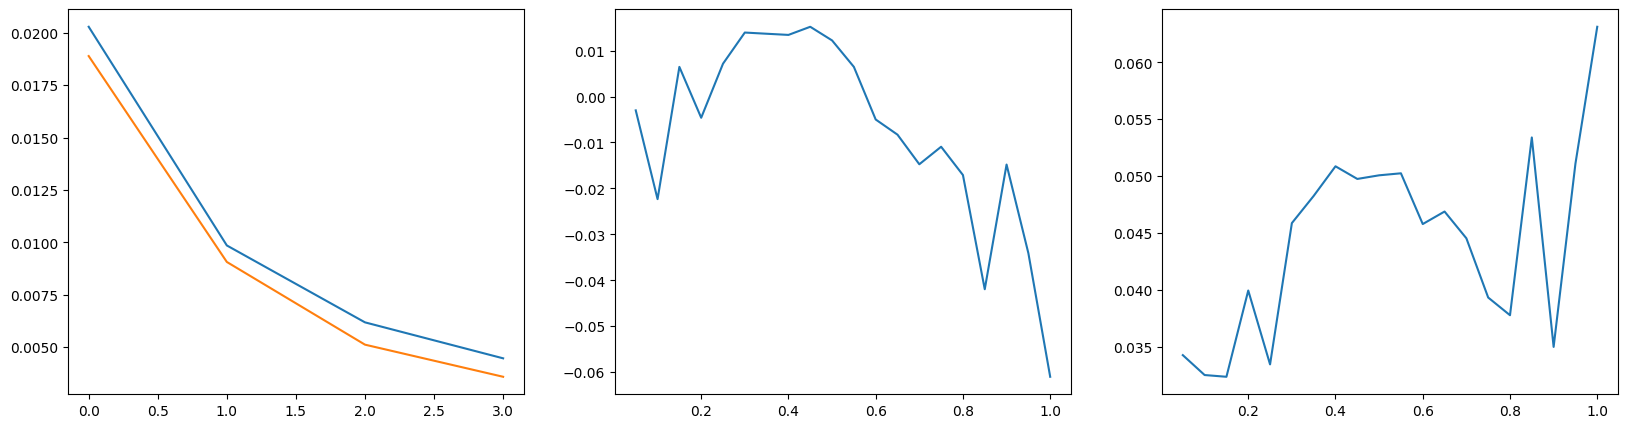

Epoch 5
-------------------------------

k-1
Avg diff: 0.047795, Avg loss: 0.003557, Min rate: 0.033147, Max rate: 1.139836  [  800/10285]
Avg diff: 0.050390, Avg loss: 0.003934, Min rate: 0.060579, Max rate: 1.011249  [ 1600/10285]
Avg diff: 0.046762, Avg loss: 0.003246, Min rate: 0.062622, Max rate: 0.965891  [ 2400/10285]
Avg diff: 0.047036, Avg loss: 0.003242, Min rate: 0.178662, Max rate: 1.128339  [ 3200/10285]
Avg diff: 0.046620, Avg loss: 0.003202, Min rate: 0.130098, Max rate: 1.007042  [ 4000/10285]
Avg diff: 0.048154, Avg loss: 0.003581, Min rate: 0.117263, Max rate: 1.030625  [ 4800/10285]
Avg diff: 0.049116, Avg loss: 0.003437, Min rate: 0.139941, Max rate: 0.968562  [ 5600/10285]
Avg diff: 0.046376, Avg loss: 0.003396, Min rate: 0.098795, Max rate: 0.958314  [ 6400/10285]
Avg diff: 0.043327, Avg loss: 0.002688, Min rate: 0.025080, Max rate: 0.888113  [ 7200/10285]
Avg diff: 0.046222, Avg loss: 0.003279, Min rate: 0.017053, Max rate: 1.063201  [ 8000/10285]
Avg diff: 0.044

C:\Users\yrasi\AppData\Local\Temp\ipykernel_2148\2076441446.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('range', as_index=False).mean()


Test Results: 
 Accuracy: 0.078276, Avg loss: 0.002418, Min rate: -0.035083, Max rate: 1.087913, Max diff 0.381696


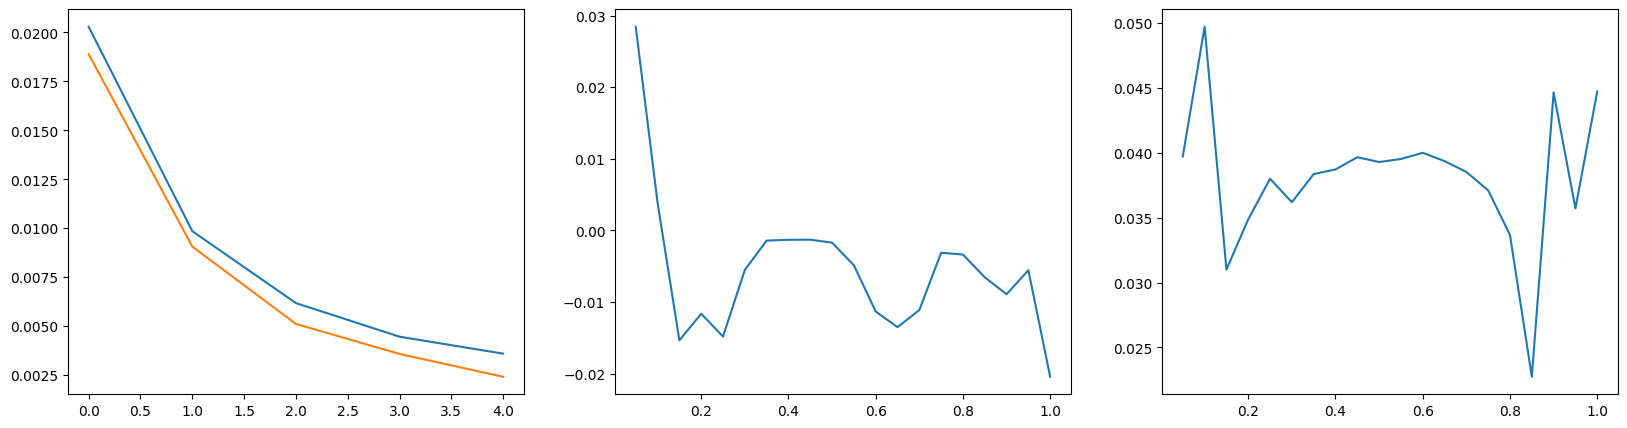

Epoch 6
-------------------------------

k-1
Avg diff: 0.043361, Avg loss: 0.002814, Min rate: 0.134968, Max rate: 0.972624  [  800/10285]
Avg diff: 0.039955, Avg loss: 0.002283, Min rate: 0.069454, Max rate: 0.980960  [ 1600/10285]
Avg diff: 0.040583, Avg loss: 0.002324, Min rate: 0.220966, Max rate: 1.001586  [ 2400/10285]
Avg diff: 0.041163, Avg loss: 0.002668, Min rate: 0.098928, Max rate: 1.012763  [ 3200/10285]
Avg diff: 0.045498, Avg loss: 0.003143, Min rate: 0.174595, Max rate: 0.953229  [ 4000/10285]
Avg diff: 0.041196, Avg loss: 0.002425, Min rate: 0.111422, Max rate: 1.018533  [ 4800/10285]
Avg diff: 0.040446, Avg loss: 0.002452, Min rate: 0.048917, Max rate: 0.984063  [ 5600/10285]
Avg diff: 0.041065, Avg loss: 0.002533, Min rate: 0.004067, Max rate: 1.002743  [ 6400/10285]
Avg diff: 0.040055, Avg loss: 0.002216, Min rate: 0.161617, Max rate: 1.003991  [ 7200/10285]
Avg diff: 0.041640, Avg loss: 0.002603, Min rate: 0.042684, Max rate: 0.974304  [ 8000/10285]
Avg diff: 0.041

C:\Users\yrasi\AppData\Local\Temp\ipykernel_2148\2076441446.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('range', as_index=False).mean()


Test Results: 
 Accuracy: 0.079422, Avg loss: 0.002721, Min rate: -0.038073, Max rate: 1.080441, Max diff 0.440185


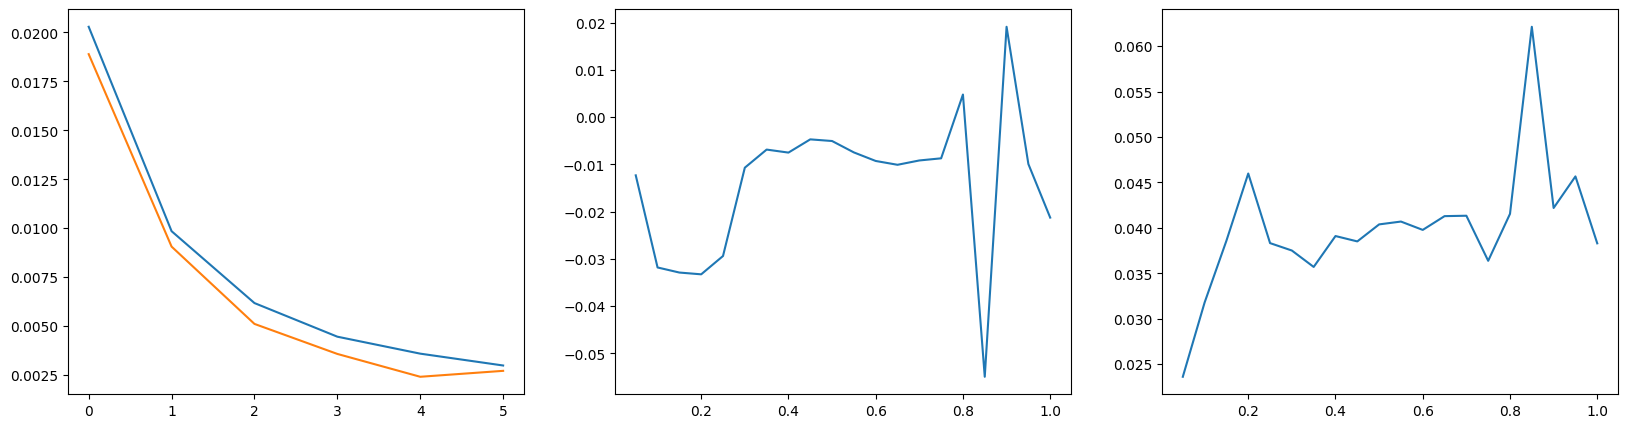

Epoch 7
-------------------------------

k-1
Avg diff: 0.039764, Avg loss: 0.002573, Min rate: 0.001297, Max rate: 0.889610  [  800/10285]
Avg diff: 0.040653, Avg loss: 0.002724, Min rate: 0.028780, Max rate: 0.981049  [ 1600/10285]
Avg diff: 0.037958, Avg loss: 0.002112, Min rate: 0.146146, Max rate: 1.034821  [ 2400/10285]
Avg diff: 0.039017, Avg loss: 0.002216, Min rate: 0.126778, Max rate: 1.035921  [ 3200/10285]
Avg diff: 0.038133, Avg loss: 0.002396, Min rate: 0.108340, Max rate: 1.061341  [ 4000/10285]
Avg diff: 0.039928, Avg loss: 0.003033, Min rate: 0.068079, Max rate: 1.041076  [ 4800/10285]
Avg diff: 0.038511, Avg loss: 0.002354, Min rate: 0.062651, Max rate: 0.985368  [ 5600/10285]
Avg diff: 0.040420, Avg loss: 0.002681, Min rate: 0.091131, Max rate: 1.090431  [ 6400/10285]
Avg diff: 0.037783, Avg loss: 0.002001, Min rate: 0.094682, Max rate: 0.976817  [ 7200/10285]
Avg diff: 0.038951, Avg loss: 0.002226, Min rate: 0.108147, Max rate: 1.002625  [ 8000/10285]
Avg diff: 0.038

C:\Users\yrasi\AppData\Local\Temp\ipykernel_2148\2076441446.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('range', as_index=False).mean()


Test Results: 
 Accuracy: 0.067153, Avg loss: 0.001842, Min rate: -0.005165, Max rate: 1.093005, Max diff 0.384550


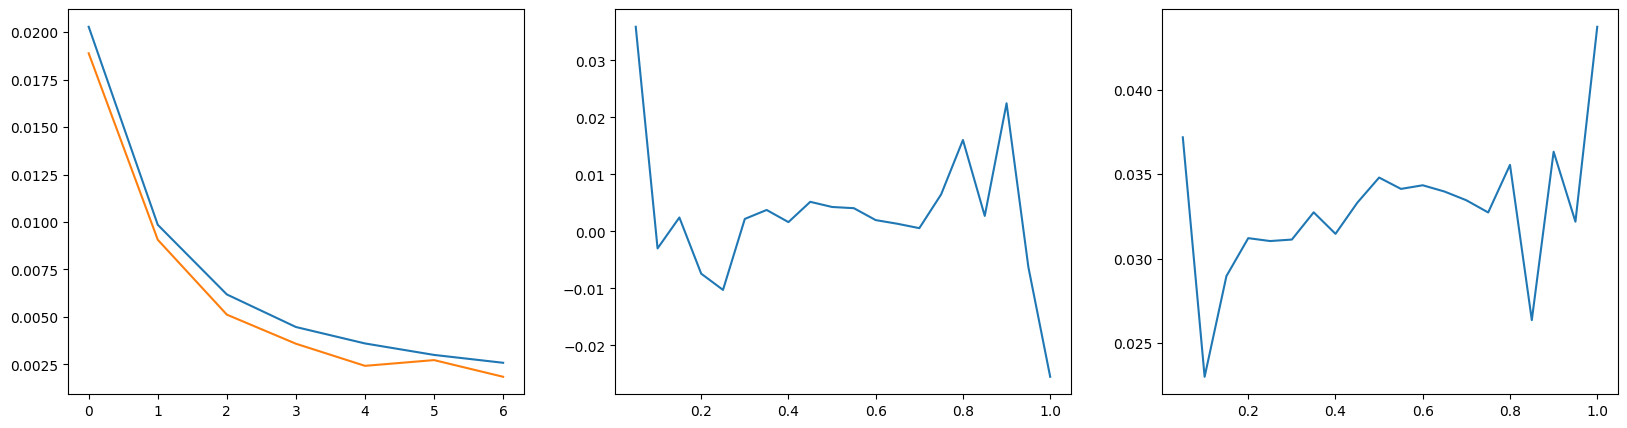

Epoch 8
-------------------------------

k-1
Avg diff: 0.035081, Avg loss: 0.001967, Min rate: 0.010748, Max rate: 1.028668  [  800/10285]
Avg diff: 0.036607, Avg loss: 0.001931, Min rate: 0.112069, Max rate: 0.969911  [ 1600/10285]
Avg diff: 0.034980, Avg loss: 0.001893, Min rate: 0.127601, Max rate: 1.013350  [ 2400/10285]
Avg diff: 0.035909, Avg loss: 0.002021, Min rate: 0.111081, Max rate: 0.961353  [ 3200/10285]
Avg diff: 0.038508, Avg loss: 0.002451, Min rate: 0.160502, Max rate: 1.035440  [ 4000/10285]
Avg diff: 0.035577, Avg loss: 0.001891, Min rate: -0.017310, Max rate: 0.974987  [ 4800/10285]
Avg diff: 0.035636, Avg loss: 0.001832, Min rate: 0.039567, Max rate: 0.915919  [ 5600/10285]
Avg diff: 0.036295, Avg loss: 0.001889, Min rate: 0.077698, Max rate: 1.009024  [ 6400/10285]
Avg diff: 0.035108, Avg loss: 0.001799, Min rate: 0.108355, Max rate: 1.013046  [ 7200/10285]
Avg diff: 0.036896, Avg loss: 0.002273, Min rate: 0.127954, Max rate: 0.992332  [ 8000/10285]
Avg diff: 0.03

C:\Users\yrasi\AppData\Local\Temp\ipykernel_2148\2076441446.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('range', as_index=False).mean()


Test Results: 
 Accuracy: 0.068012, Avg loss: 0.001931, Min rate: -0.024201, Max rate: 1.060375, Max diff 0.329817


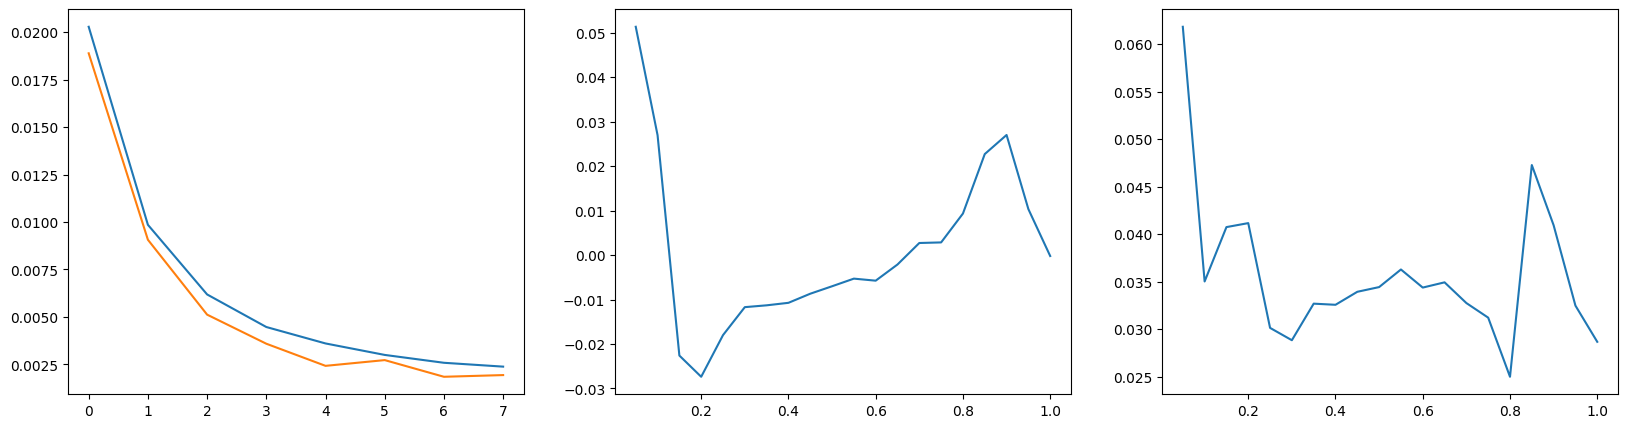

Epoch 9
-------------------------------

k-1
Avg diff: 0.032011, Avg loss: 0.001615, Min rate: 0.046941, Max rate: 0.983194  [  800/10285]
Avg diff: 0.034351, Avg loss: 0.001780, Min rate: 0.004869, Max rate: 0.967983  [ 1600/10285]
Avg diff: 0.034877, Avg loss: 0.002063, Min rate: 0.019906, Max rate: 0.988070  [ 2400/10285]
Avg diff: 0.034407, Avg loss: 0.001875, Min rate: 0.135653, Max rate: 0.981403  [ 3200/10285]
Avg diff: 0.036276, Avg loss: 0.002133, Min rate: 0.122938, Max rate: 0.981643  [ 4000/10285]
Avg diff: 0.036857, Avg loss: 0.001958, Min rate: 0.026641, Max rate: 0.961495  [ 4800/10285]
Avg diff: 0.036526, Avg loss: 0.002106, Min rate: 0.162477, Max rate: 1.018562  [ 5600/10285]
Avg diff: 0.035417, Avg loss: 0.001931, Min rate: 0.128915, Max rate: 1.057034  [ 6400/10285]
Avg diff: 0.034050, Avg loss: 0.001712, Min rate: 0.029642, Max rate: 0.972227  [ 7200/10285]
Avg diff: 0.034465, Avg loss: 0.001917, Min rate: 0.135410, Max rate: 1.028726  [ 8000/10285]
Avg diff: 0.036

C:\Users\yrasi\AppData\Local\Temp\ipykernel_2148\2076441446.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('range', as_index=False).mean()


Test Results: 
 Accuracy: 0.059131, Avg loss: 0.001409, Min rate: -0.062985, Max rate: 1.021006, Max diff 0.346088


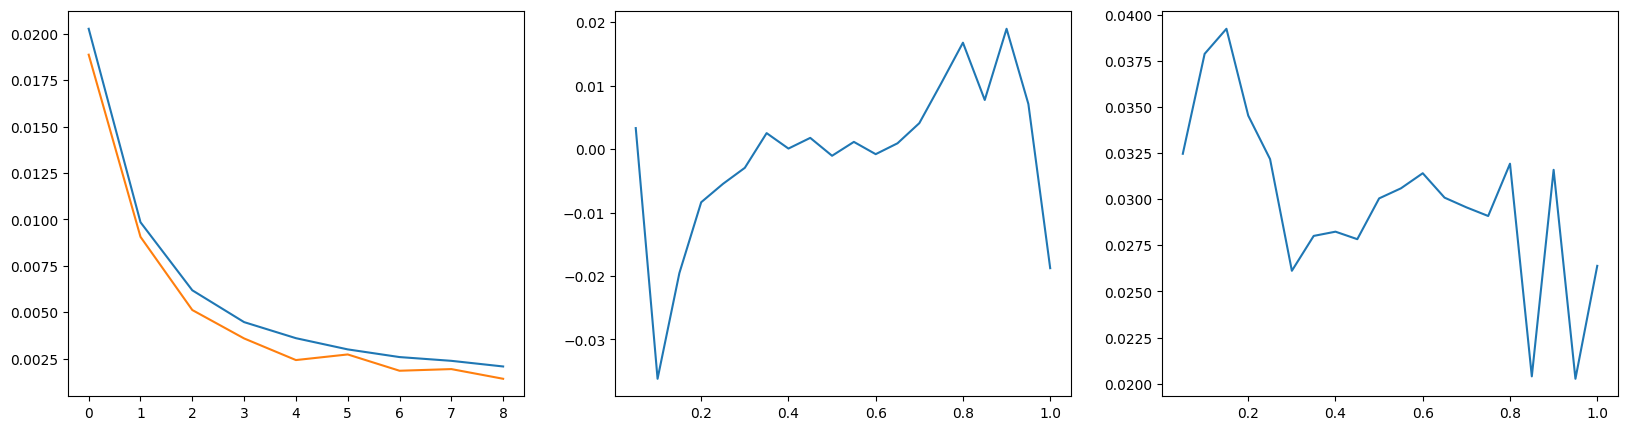

Epoch 10
-------------------------------

k-1
Avg diff: 0.031291, Avg loss: 0.001442, Min rate: -0.007924, Max rate: 1.003300  [  800/10285]
Avg diff: 0.032345, Avg loss: 0.001553, Min rate: -0.016053, Max rate: 1.039006  [ 1600/10285]
Avg diff: 0.031606, Avg loss: 0.001445, Min rate: 0.010474, Max rate: 1.014159  [ 2400/10285]
Avg diff: 0.030367, Avg loss: 0.001347, Min rate: 0.079905, Max rate: 0.963777  [ 3200/10285]


KeyboardInterrupt: 

In [17]:
for t in range(10):
    print(f"Epoch {t + 1}\n-------------------------------")

    train_results = []
    test_results = []
    for k, test_df in enumerate(samples):
        print(f"\nk-{k + 1}")
        train_df = pd.concat([sample for sample in samples if sample is not test_df], ignore_index=True)
        train_data = Dataset(train_df, transforms=transform)
        test_data = Dataset(test_df, transforms=test_transform)
        train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
        train_result = train_loop(train_dataloader, model, weighted_mse_loss, optimizer, batch_size)
        test_result = test_loop(test_dataloader, model, weighted_mse_loss)
        train_results.append(train_result)
        test_results.append(test_result)

    train_result = TrainResult.concat(train_results)
    test_result = TestResult.concat(test_results)
    epochs.append(t)
    train_y.append(mean(train_result.losses))
    test_y.append(test_result.loss)

    if test_result.loss < best_state['loss']:
        best_state['accuracy'] = test_result.accuracy
        best_state['loss'] = test_result.loss
        best_state['diff'] = test_result.diff
        best_state['min_rate'] = test_result.min_rate
        best_state['max_rate'] = test_result.max_rate
        best_state['max_diff'] = test_result.max_diff
        best_state['epoch'] = t + 1
        best_state['state'] = deepcopy(model.state_dict())
        torch.save(model, 'current-w_full_EfficientNetV2-S.pth')

    print(
        results_template.format(
            test_result.accuracy,
            test_result.loss,
            test_result.min_rate,
            test_result.max_rate,
            test_result.max_diff
        )
    )
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
    ax1.plot(epochs, train_y)
    ax1.plot(epochs, test_y)
    ax2.plot(test_result.df['range'], test_result.df['diffs'])
    ax3.plot(test_result.df['range'], test_result.df['abs_diffs'])
    plt.show()